# Introduction
In this document we explain how to implement the gradient methods Gradient Decsnet (**GD**), Stochastic Gradient Decsnet (**SGD**), Stochastic Variance Reduced Gradient (**SVRG**) and finally Stochastic Average Gradient (**SAG**).


## A regression problem

Here we use the gradient methods to minimize the **logistic ridge regression** defined as following:
\begin{align}
f= \frac{1}{n}\sum_{i=1}^n \log\bigg(1+\exp (-y_i \mathbf{W}^T x_i)\bigg)+\lambda\lvert\lvert\mathbf{W}\rvert\rvert^2
\end{align}


Consider the following data formats:
* $X$ is a $p \times n$ matrix
* $Y$ is a $1 \times n$ matrix
* $W$ is a $p \times 1$ matrix


## Computing the gradient
\begin{align}
\nabla f= \frac{1}{N}\sum_{i\in[N]}\frac{-y_i}{e^{y_i w^T x_i}+1}x_i + 2\lambda w
\end{align}


## Dataset
We are testing the methods on *the greenhouse gas*. Data has 16 rows. We take the first 15 rows of the data as the inout  𝑋  and the first element of the 16th row as the target  𝑌 . The data contains 2921 samples which we are using the last 2920 samples.


In [67]:
##imports from libraries
import numpy  as np
import pandas as pd
import random
from   pathlib import Path
import time
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm


## Data preparation
For simplicity and avoid loading all small samples each time, we have stored the loaded files into "data_x.csv" and "data_y.csv".

We also split the dataset in half to obtain train and test data.

In [14]:
#Load
path = Path(Path().absolute())
DataPath=str(path)+'/Data/'
X_ = np.array(pd.read_csv(DataPath+"data_x.csv",header=0).iloc[:,:])
Y_ = np.array(pd.read_csv(DataPath+"data_y.csv",header=0).iloc[:,:])


# Split train and test data here: (X_train, Y_train, X_test, Y_test)
X_train=X_[:,0:X_.shape[1]//2]
Y_train=Y_[0,0:Y_.shape[1]//2]

X_test=X_[:,X_.shape[1]//2:]
Y_test=Y_[0,Y_.shape[1]//2:]


In [94]:
## Logistic ridge regression with different optimizers
# cost function and gradient calculation

def Logistic_Ridge_Cost(X, Y, W, lambda_ = 0.01):
    # X is p by n
    # Y is 1 by n
    # W is p by 1   
    p, n = X.shape
    value = 0
    for i in range(n):
        Z = -1 * Y[i] * np.matmul(W.T , (X[:,i]).reshape(p,1))
        value += np.log(1+np.exp(Z))
    norm_w = np.linalg.norm(W)
    c2 = lambda_ * norm_w ** 2
    return value/n + c2 

def Function_Gradient(X, Y, W, lambda_ = 0.01):
    # X is p by n
    # Y is 1 by n
    # W is p by 1   
    p, n = X.shape
    value = np.zeros((p,1))
    for i in range(n):       
        Z = Y[i] * np.matmul(W.T , (X[:,i]).reshape(p,1))
        Q=(-Y[i]/(1+np.exp(Z)))*(X[:,i]).reshape(p,1)        
        value += Q
        
    return value/n+2*lambda_*W


## GD
\begin{align} 
&\text{initialize } w_1\\
&\text{for } k = 1,2,...,K\\
&  \qquad  \text{Compute the gradient } g(w_k)\\
&  \qquad  \text{Update } w_{k+1}=w_k - \alpha g(w_k)
\end{align}    

In [58]:
def GD(X,Y, W, alpha, num_iters , lambda_ , epsilon):
    # X is p by n
    # Y is q by n
    # W is p by q
    cost_v=[]
    pbar = tqdm(total=num_iters)
    

    for i in range(num_iters):
        # update the parameter w for GD here:
        g = Function_Gradient(X, Y, W, lambda_)                        
        W = W-alpha*g
        cost_ = Logistic_Ridge_Cost(X_test,Y_test,W,lambda_)[0]
        #print('\t cost=',cost_)
        cost_v.append(cost_)
        pbar.update(1)
        if (np.linalg.norm(g) <= epsilon):
            break
    pbar.close()
    return W,cost_v


In [95]:
## Solving the optimization problem:
# Setting the values here:
num_iters = 2000
alpha=2e-1
lambda_=1e-2
epsilon=1e-6


p,n = X_train.shape
W_init = np.random.rand(p,1)*0.5  # Initialization of w
print("Initial cost: ",Logistic_Ridge_Cost(X_test,Y_test,W_init,lambda_))

start=time.time()
gde,cost_GD = GD(X_train,Y_train,W_init,alpha,num_iters,lambda_,epsilon)
end = time.time()
cost_value = Logistic_Ridge_Cost(X_test,Y_test,gde,lambda_)
print("Cost of GD after convergence: ",cost_value)
print("Training time for GD: ", end-start , ' sconds')


Initial cost:  [[4.06279131]]


Cost of GD after convergence:  [[0.01457761]]
Training time for GD:  212.849915266037  sconds


Now we can plot the loss function with respect to itearations. Note that the loss needs to converge eventually.
In this experiment we have stopped at **1000** iterations.

Text(0.5, 0, 'iterations')

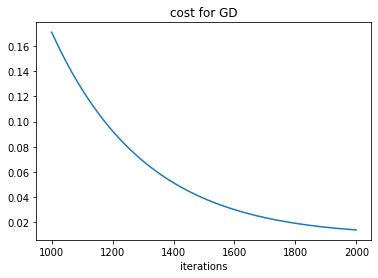

In [83]:
plt.plot(np.arange(1000,2000),cost_GD[1000:])
plt.title('cost for GD')
plt.xlabel('iterations')

## SGD
In general this can be done in a generic way by assuming a radnomness in creating the gradients. Here we mention on implementation which we take random batches from the data to compute the gradient descent.
\begin{align} 
&\text{initialize } w_1\\
&\text{for } k = 1,2,...,K\\
&  \qquad  \text{Randomly select a set of indices} \mathcal{I}^b\\
&  \qquad  \text{Compute the gradient } g(w_k,\mathcal{I}^b)\\
&  \qquad  \text{Update } w_{k+1}=w_k - \alpha g(w_k,\mathcal{I}^b)
\end{align}   

In [86]:
def SGD(X,Y, W, alpha, num_iters , lambda_ , epsilon, batchSize=10):
    # X is p by n
    # Y is q by n
    # W is p by q
    cost_v=[]
    pbar = tqdm(total=num_iters)
    

    #computes the SGD with respect to random mini-batches
    p,n=X.shape
    for i in range(num_iters):
        # get minibatch
        X_mini, Y_mini = miniBatch(X,Y,batchSize)
        # update the parameter w for SGD here:
        g = Function_Gradient(X_mini, Y_mini, W, lambda_)
        W = W-alpha*g
        cost_ = Logistic_Ridge_Cost(X_test,Y_test,W,lambda_)[0]
        #print('\t cost=',cost_)
        cost_v.append(cost_)
        pbar.update(1)
        
        if (np.linalg.norm(g) <= epsilon):
            break
    pbar.close()
    return W,cost_v

##Funtion to get mini batch sgd
def miniBatch(X,Y,batchSize):
    # X is p by n
    # Y is q by n
    # W is p by q    
    p,n=X.shape
    X_mini=np.zeros((p,batchSize))
    Y_mini=np.zeros((batchSize,))
    indexArray = random.sample(range(n), batchSize)
    for i in range(batchSize):
        X_mini[:,i]=X[:,indexArray[i]]
        Y_mini[i,] =Y[indexArray[i],]
    return X_mini,Y_mini

In [97]:
## Solving the optimization problem:
# Setting the values here:
num_iters = 2000
alpha=2e-1
lambda_=1e-2
epsilon=1e-6
bSize=1


p,n = X_train.shape
#W_init = np.random.rand(p,1)*0.5  # Initialization of w
print("Initial cost: ",Logistic_Ridge_Cost(X_test,Y_test,W_init,lambda_))

start=time.time()
gde,cost_SGD = SGD(X_train,Y_train,W_init,alpha,num_iters,lambda_,epsilon,batchSize=bSize)
end = time.time()
cost_value = Logistic_Ridge_Cost(X_test,Y_test,gde,lambda_)
print("Cost of SGD after convergence: ",cost_value)
print("Training time for SGD: ", end-start , ' sconds')

Initial cost:  [[4.06279131]]


Cost of SGD after convergence:  [[0.015772]]
Training time for SGD:  57.43988513946533  sconds


Text(0.5, 0, 'iterations')

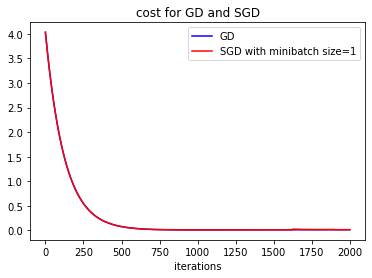

In [99]:
plt.plot(np.arange(0,2000),cost_GD[:],color='blue',label='GD')
plt.plot(np.arange(0,2000),cost_SGD[:],color='red',label='SGD with minibatch size=1')
plt.legend()
plt.title('cost for GD and SGD')
plt.xlabel('iterations')